In [1]:
# Import Yahoo Finance API
import yfinance as yf

# Import backtesting utils
import backtest_tools.portfolio_tools as backtest

# Import utils
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [27]:
# Get portfolio weights from csv
mvo_weights = pd.read_csv(r'portfolio_reports_1-31-23/mvo_weights_1-30-23.csv').set_index('Date')
mvo_weights = mvo_weights.iloc[-1]

tickers = mvo_weights.index
returns = pd.DataFrame()

for ticker in tickers:

    # Get trailing month's worth of stock prices
    prices = yf.download(ticker, start=dt.date.today()-BDay(20*6), end=dt.date.today())['Adj Close']

    # Get raw asset returns
    raw_rets = prices.pct_change()
    raw_rets = raw_rets.rename(ticker)
    returns = pd.concat([returns, raw_rets], axis=1)

raw_returns = returns.dropna()
weighted_returns = pd.Series(raw_returns.dot(mvo_weights), name='TAMID').dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Get performance summary and format

In [28]:
# Initialize portfolio performance pd.DataFrame
portfolio_performance = pd.DataFrame()

# Iterate through raw stock returns
for ticker, returns in raw_returns.items():
    # Scale returns to default vol (10%) to ensure direct comparison of CAGR and other relevant values
    returns = backtest.scale_vol(returns)
    # Get performance summary
    ticker_performance = backtest.performance_summary(returns)
    ticker_performance.name = ticker
    # Append to aggregate pd.DataFrame
    portfolio_performance = pd.concat([portfolio_performance, ticker_performance], axis=1)

# Add performance for TAMID portfolio to aggregate performance pd.DataFrame
portfolio_performance['TAMID'] = backtest.performance_summary(weighted_returns)



In [29]:
# Format
portfolio_performance = portfolio_performance.T.sort_values(by=['CAGR', 'Sharpe Ratio'], ascending=False)
portfolio_performance = portfolio_performance[['Sharpe Ratio', 'CAGR', 'Skew', 'Kurtosis', 'CVaR - Laplace', 'Max Drawdown']]
# Add MVO weights as a column
portfolio_performance['Portfolio Weights'] = mvo_weights
portfolio_performance.index.name = 'Portfolio Holdings'
portfolio_performance = np.round(portfolio_performance, 3)
portfolio_performance

,Sharpe Ratio,CAGR,Skew,Kurtosis,CVaR - Laplace,Max Drawdown,Portfolio Weights
Portfolio Holdings,,,,,,,
TAMID,1.336,0.607,0.131,3.424,-0.107,-0.255,NaN
ACLS,1.856,0.213,0.105,4.148,-0.029,-0.076,0.472
FTAI,1.333,0.155,0.558,3.663,-0.030,-0.044,0.020
DAL,0.668,0.078,0.218,3.638,-0.031,-0.051,0.020
GOOS,0.521,0.068,-0.047,2.736,-0.030,-0.055,0.020
TSM,0.449,0.045,1.003,5.753,-0.032,-0.088,0.020
ISRG,0.394,0.045,0.804,5.641,-0.032,-0.054,0.020
PLYM,0.324,0.034,0.187,5.078,-0.032,-0.070,0.020
TXN,-0.136,0.007,0.299,3.217,-0.032,-0.055,0.020


Save performance table to excel

In [79]:
portfolio_performance.to_clipboard()

In [82]:
# Store performance pd.DataFrame in excel for newsletter visualization
portfolio_performance.to_excel(r'portfolio_reports_1-31-23/portfolio_performance.xlsx')

Get SPY returns and run Alpha Regression (TAMID ~ SPY)

In [86]:
# Get trailing 6-month's worth of stock prices
spy_prices = yf.download('SPY', start=dt.date.today()-BDay(20*6), end=dt.date.today())['Adj Close']

# Get raw asset returns
spy_returns = spy_prices.pct_change().dropna()
spy_returns = spy_returns.rename('SPY')

alpha_regression = np.round(backtest.alpha_regression(pd.Series(weighted_returns, name='TAMID'), spy_returns), 3)

alpha_regression.to_excel(r'portfolio_reports_1-31-23/alpha_regression.xlsx')

[*********************100%***********************]  1 of 1 completed


Plot returns + OLS

In [132]:
import statsmodels.api as sm 

# Construct OLS regression of portfolio returns over time

# Get numerical values of time as exog variable
date_index = np.arange(weighted_returns.index.size)
exog = sm.add_constant(date_index)  

# Build model
model = sm.OLS(weighted_returns, exog)
portfolio_regression = model.fit()

# Get regression params
alpha = portfolio_regression.params[0]
beta = portfolio_regression.params[0]

# Compute best fit line and format
reg_pred = date_index * beta + alpha
reg_pred = pd.Series(reg_pred, index=weighted_returns.index, name='TAMID OLS Regression')

Genreate all relevant subplots for a uniform format

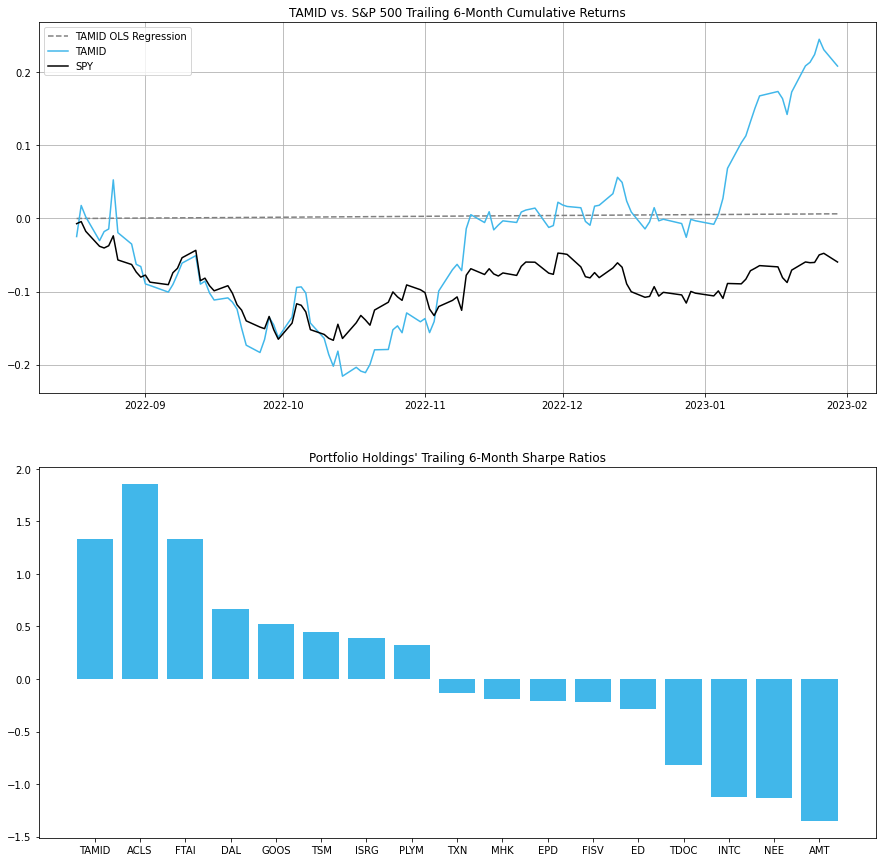

In [133]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))
# Increase the space between subplots
fig.subplots_adjust(hspace=.2)

tamid_color = '#41B7EA'
# ------------------------------------------ Plot Returns ------------------------------------------ 
# Add gridlines
ax1.grid()
# Set the 1st subplot's title
ax1.set_title("TAMID vs. S&P 500 Trailing 6-Month Cumulative Returns")
# Plot each series individually
ax1.plot(reg_pred, color='Grey', label=reg_pred.name, linestyle='dashed')
ax1.plot(backtest.cumulative_returns(weighted_returns), color=tamid_color, label=weighted_returns.name)
ax1.plot(backtest.cumulative_returns(spy_returns), color='Black', label=spy_returns.name)
ax1.legend()



# ------------------------------------------ Plot Sharpe Ratio Bar Chart Analysis ------------------------------------------ 
# Set the 2nd subplot's title
ax2.set_title("Portfolio Holdings' Trailing 6-Month Sharpe Ratios")
ax2.bar(portfolio_performance['Sharpe Ratio'].index, portfolio_performance['Sharpe Ratio'], color=tamid_color)
ax1.legend()